In [ ]:
import os
import shutil
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
import cv2
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, Flatten, Dropout, Conv2D, Input, Rescaling
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory, load_img
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [85]:
df = pd.read_csv("dataset/labels.csv", header=None, names=["image_id", "class_label", "x_min", "y_min", "x_max", "y_max"])
df = df.head(889)

image_folder = "./dataset/Images"
X, y = [], []

for _, row in df.iterrows():
    img_path = os.path.join(image_folder, f"{int(row['image_id']):08d}.jpg")

    img = cv2.imread(img_path)
    
    if img is None:
        print(f"Warning: Could not read image {img_path}. Skipping...")
        continue  # Skip this image and move on

    img = cv2.resize(img, (224, 224)) / 255.0  # Normalize

    # Bounding box coordinates (rescaled to [0, 1] range relative to image size)
    bbox = np.array([row["x_min"] / 224, row["y_min"] / 224, row["x_max"] / 224, row["y_max"] / 224])
    
    X.append(img)
    y.append(bbox)

X = np.array(X)
y = np.array(y)

print(f"Loaded {len(X)} images and labels.")

Loaded 889 images and labels.


In [86]:
label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df["class_label"])
y_labels = to_categorical(df["label_encoded"], num_classes=len(label_encoder.classes_))

print(y_labels.shape)

(889, 11)


In [87]:
for _, row in df.iterrows():
    src_path = os.path.join(image_folder, f"{int(row['image_id']):08d}.jpg")
    class_name = str(row["class_label"])
    
    dst_folder = os.path.join("./dataset/classified-images", class_name)
    os.makedirs(dst_folder, exist_ok=True)
    
    dst_path = os.path.join(dst_folder, f"{int(row['image_id']):08d}.jpg")
    shutil.copy(src_path, dst_path)

In [88]:
img_dir = "./dataset/classified-images"

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(img_dir, target_size=(224, 224),
                                         batch_size=32, class_mode='categorical',
                                         subset="training")

val_data = datagen.flow_from_directory(img_dir, target_size=(224, 224),
                                       batch_size=32, class_mode='categorical',
                                       subset="validation")

Found 359 images belonging to 11 classes.
Found 87 images belonging to 11 classes.


In [89]:
# Define input layer
input_layer = Input(shape=(224, 224, 3))

# Feature extraction (CNN)
x = Conv2D(32, (3,3), activation="relu")(input_layer)
x = Conv2D(64, (3,3), activation="relu")(x)
x = Flatten()(x)

# Bounding box output (4 values: x_min, y_min, x_max, y_max)
bbox_output = Dense(4, activation="sigmoid", name="bbox")(x)

# Class label output (classification)
class_output = Dense(len(label_encoder.classes_), activation="softmax", name="class")(x)

# Define model
model = Model(inputs=input_layer, outputs=[bbox_output, class_output])
model.compile(
    optimizer='adam',
    loss={
        "bbox": "mean_squared_error",
        "class": "categorical_crossentropy"
    },
    metrics={
        "bbox": [],        # no metrics needed for regression
        "class": ["accuracy"]  # accuracy for classification
    }
)

print(model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 222, 222,  │        896 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 220, 220,  │     18,496 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 3097600)   │          0 │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox (Dense)        │ (None, 4)         │ 12,390,404 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class (Dense)       │ (None, 11)        │ 34,073,611 │ flatten_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 46,483,407 (177.32 MB)

 Trainable params: 46,483,407 (177.32 MB)

 Non-trainable params: 0 (0.00 B)

None


In [90]:
history = model.fit(
    X,
    {"bbox": y, "class": y_labels},
    validation_split=0.2,
    epochs=10
)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - bbox_loss: 0.7959 - class_accuracy: 0.5118 - class_loss: 34.4891 - loss: 35.3320 - val_bbox_loss: 0.7274 - val_class_accuracy: 0.6292 - val_class_loss: 1.5821 - val_loss: 2.2866
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - bbox_loss: 0.6267 - class_accuracy: 0.6836 - class_loss: 1.1866 - loss: 1.8130 - val_bbox_loss: 0.7098 - val_class_accuracy: 0.6404 - val_class_loss: 1.5471 - val_loss: 2.2501
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - bbox_loss: 0.6257 - class_accuracy: 0.7120 - class_loss: 0.9242 - loss: 1.5514 - val_bbox_loss: 0.7076 - val_class_accuracy: 0.6404 - val_class_loss: 1.6978 - val_loss: 2.3814
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - bbox_loss: 0.5801 - class_accuracy: 0.7326 - class_loss: 0.7223 - loss: 1.3032 - val_bbox_loss: 0.7040 - val_class_accuracy: 0.6348 - val_class_loss: 1.5301 - val_loss: 2.2210
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - bbox_loss: 0.6071 - class_accuracy

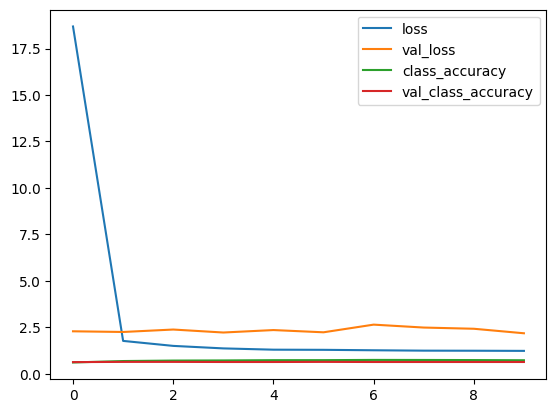

In [91]:
# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['class_accuracy'])
plt.plot(history.history['val_class_accuracy'])
plt.legend(['loss', 'val_loss','class_accuracy', 'val_class_accuracy'], loc='upper right')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
Predicted Class: car
Predicted Bounding Box: [0.45299911 0.45114523 0.70849836 0.6220113 ]


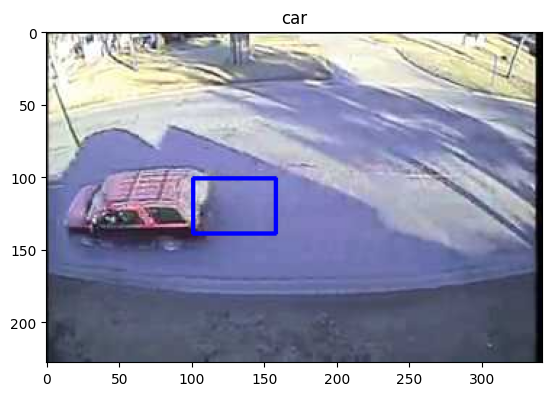

In [92]:
# Load test image
test_image_path = "sample-image.jpg"
test_img = cv2.imread(test_image_path)
test_img_resized = cv2.resize(test_img, (224, 224)) / 255.0
test_img_array = np.expand_dims(test_img_resized, axis=0)

# Predict bounding box and class
bbox_pred, class_pred = model.predict(test_img_array)
predicted_class = label_encoder.inverse_transform([np.argmax(class_pred)])

print(f"Predicted Class: {predicted_class[0]}")
print(f"Predicted Bounding Box: {bbox_pred[0]}")

# Visualize bounding box
x_min, y_min, x_max, y_max = bbox_pred[0] * 224
cv2.rectangle(test_img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (255, 0, 0), 2)

plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.title(predicted_class[0])
plt.show()